# Import Libraries

In [1]:
import numpy as np
import os
import cv2
from prettytable import PrettyTable
from matplotlib import pyplot as plt
import pathlib
import itertools

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout, BatchNormalization, LeakyReLU

# Create Data

To capture images for training use the following command

python capture.py --grayscale --name thumbsup --mode training
* Above command will open a window with video stream from your webcam.
* There is a rectangle box on the top left corner, this will be the area captured and saved to disk.
* Click "s" to capture the current frame and save to disk , click "q" to exit.
* images will be saved under data/{training|test}/{name}/{name}-1.jpg

# Data Overview

In [2]:
# Training image path
imagepaths_train = []

for root, dirs, files in os.walk("data/training", topdown=False): 
    for name in files:
        path = os.path.join(root, name)
        if path.endswith("jpg"):
            imagepaths_train.append(path)

print('Number of Training Data:', len(imagepaths_train))

Number of Training Data: 500


In [3]:
# Test image path
imagepaths_test = []

for root, dirs, files in os.walk("data/test", topdown=False): 
    for name in files:
        path = os.path.join(root, name)
        if path.endswith("jpg"):
            imagepaths_test.append(path)

print('Number of Test Data:', len(imagepaths_test))

Number of Test Data: 100


In [4]:
def plot_image(path):
    img = cv2.imread(path)
    print('image shape:', img.shape)
    plt.imshow(img)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image " + path)

image shape: (64, 64, 3)


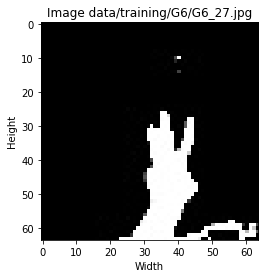

In [5]:
plot_image(imagepaths_train[0])

image shape: (64, 64, 3)


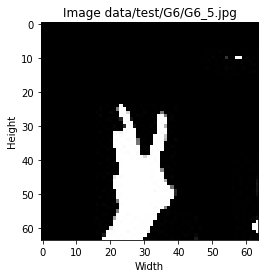

In [6]:
plot_image(imagepaths_test[0])

# Data Preprocessing

## For Traditional ML classifiers

In [7]:
X_train = [] # Image data
y_train = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths_train:
    img = cv2.imread(path) # Reads image and returns np.array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.flatten()
    X_train.append(img)
  
    # Processing label in image path
    try:
        category = path.split("\\")[1]
    except:
        category = path.split("/")[-2]
    y_train.append(category)

X_test = [] # Image data
y_test = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths_test:
    img = cv2.imread(path) # Reads image and returns np.array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.flatten()
    X_test.append(img)

    # Processing label in image path
    try:
        category = path.split("\\")[1]
    except:
        category = path.split("/")[-2]
    y_test.append(category)

## For Neural Network

In [8]:
# The iterator will return one batch of augmented images for each iteration.
batch_size=16
def get_train_generator():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range=0.2,
        shear_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        horizontal_flip=True
    )

    return train_datagen.flow_from_directory(
        training_path, target_size=(64, 64), class_mode='categorical',
        batch_size=batch_size, shuffle=True, color_mode='grayscale')


def get_test_generator():
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range=0.2,
        horizontal_flip=True
    )
    return test_datagen.flow_from_directory(
        test_path, target_size=(64, 64), class_mode='categorical', color_mode='grayscale', shuffle = False)

In [9]:
training_path = pathlib.Path('.').joinpath('data', 'training')
test_path = pathlib.Path('.').joinpath('data', 'test')
NUM_CLASSES = 10

train_generator = get_train_generator()
test_generator = get_test_generator()

Found 500 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


# Model

## Traditional ML Classifiers

In [10]:
classifiers = [
    KNeighborsClassifier(10),
    SVC(C=0.025, probability=True),
    NuSVC(probability=True,kernel='rbf',nu=0.01),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier()
    ]

In [11]:
table = PrettyTable(['Model','Score'])

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    score = round(pipe.score(X_test, y_test),4)
    table.add_row([classifier, score])

print(table)

+--------------------------------------+-------+
|                Model                 | Score |
+--------------------------------------+-------+
| KNeighborsClassifier(n_neighbors=10) |  0.13 |
|    SVC(C=0.025, probability=True)    |  0.13 |
|   NuSVC(nu=0.01, probability=True)   |  0.16 |
|       DecisionTreeClassifier()       |  0.08 |
|       RandomForestClassifier()       |  0.1  |
|         AdaBoostClassifier()         |  0.1  |
|     GradientBoostingClassifier()     |  0.12 |
|           SGDClassifier()            |  0.12 |
+--------------------------------------+-------+


## CNN

In [10]:
def create_model(num_classes):
    """
    Create modal structure
    """
    model = Sequential([
        Conv2D(32, (3, 3), padding="same",
               activation="relu", input_shape=(64, 64, 1)),
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        MaxPooling2D(),

        Conv2D(64, (3, 3), padding="same", activation="relu"),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), padding="same", activation="relu"),
        Conv2D(256, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), padding="same"),
        LeakyReLU(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.7),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [11]:
model = create_model(train_generator.num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

In [12]:
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

# steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
hist = model.fit(train_generator, steps_per_epoch=500 // batch_size, epochs=100,
                 verbose=1, validation_data=test_generator, validation_steps=1)

Epoch 1/100
31/31 [==============================] - 8s 261ms/step - loss: 2.8418 - accuracy: 0.0785 - val_loss: 2.6201 - val_accuracy: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 8s 262ms/step - loss: 2.5071 - accuracy: 0.1157 - val_loss: 3.1328 - val_accuracy: 0.0000e+00
Epoch 3/100
31/31 [==============================] - 8s 257ms/step - loss: 2.2643 - accuracy: 0.2190 - val_loss: 9.7748 - val_accuracy: 0.3125
Epoch 4/100
31/31 [==============================] - 8s 258ms/step - loss: 2.1181 - accuracy: 0.2376 - val_loss: 11.8856 - val_accuracy: 0.3125
Epoch 5/100
31/31 [==============================] - 8s 257ms/step - loss: 2.0654 - accuracy: 0.2645 - val_loss: 21.9373 - val_accuracy: 0.3125
Epoch 6/100
31/31 [==============================] - 8s 260ms/step - loss: 1.9163 - accuracy: 0.2913 - val_loss: 19.8313 - val_accuracy: 0.3125
Epoch 7/100
31/31 [==============================] - 8s 264ms/step - loss: 1.8062 - accuracy: 0.3448 - val_loss: 8.4172 - val_accur

Epoch 58/100
31/31 [==============================] - 8s 261ms/step - loss: 0.2996 - accuracy: 0.8988 - val_loss: 1.8269 - val_accuracy: 0.3438
Epoch 59/100
31/31 [==============================] - 8s 258ms/step - loss: 0.3839 - accuracy: 0.8781 - val_loss: 1.5755 - val_accuracy: 0.5312
Epoch 60/100
31/31 [==============================] - 8s 257ms/step - loss: 0.3637 - accuracy: 0.8822 - val_loss: 1.3609 - val_accuracy: 0.6250
Epoch 61/100
31/31 [==============================] - 8s 261ms/step - loss: 0.2234 - accuracy: 0.9318 - val_loss: 1.7596 - val_accuracy: 0.5000
Epoch 62/100
31/31 [==============================] - 8s 267ms/step - loss: 0.3066 - accuracy: 0.9215 - val_loss: 3.3173 - val_accuracy: 0.3438
Epoch 63/100
31/31 [==============================] - 9s 289ms/step - loss: 0.2546 - accuracy: 0.9380 - val_loss: 0.7252 - val_accuracy: 0.7812
Epoch 64/100
31/31 [==============================] - 9s 284ms/step - loss: 0.1773 - accuracy: 0.9380 - val_loss: 1.0194 - val_accuracy:

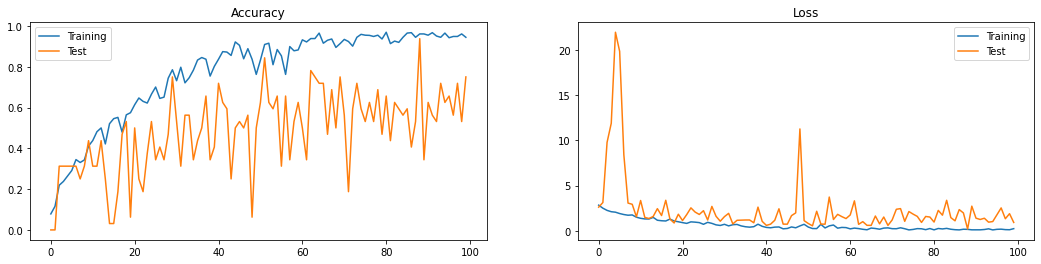

In [13]:
plt.figure(figsize=(18,4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training')
plt.plot(hist.history['val_accuracy'], label='Test')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Test')
plt.legend()
plt.title('Loss');

In [14]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

In [15]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 1, 1, 1, 1, 6, 3, 3,
       3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 3, 7, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 5, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [16]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

In [17]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [18]:
acc = accuracy(test_generator.classes, y_pred)
print('Accuracy:', acc)

Accuracy: 0.85


In [19]:
def get_classes():
    return get_test_generator().class_indices

In [20]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix'):
    """
    source: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.get_cmap("Spectral")
    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Found 100 images belonging to 10 classes.
Normalized confusion matrix


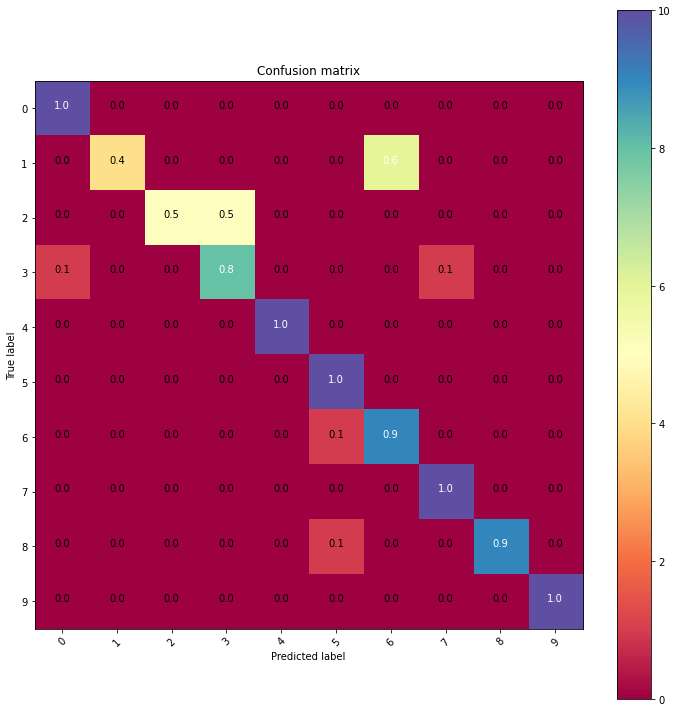

In [21]:
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, get_classes().values(), 'Confusion matrix')
plt.show()

# Save model

In [22]:
# Save model for live prediction
model.save('hand_symbols.h5')